<a href="https://colab.research.google.com/github/sverdoot/optimizer-SUG-torch/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Optimization project")
os.getcwd()

file_path = "./CIFAR10"
#directory = os.path.dirname(file_path)

try:
    os.stat(file_path)
except:
    os.mkdir(file_path)       

In [0]:
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time

In [0]:
import torch
from torch.optim import Optimizer
import math
import copy

class SUG(Optimizer):
    def __init__(self, params, l_0, d_0=0, prob=1., eps=1e-4, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if l_0 < 0.0:
            raise ValueError("Invalid Lipsitz constant of gradient: {}".format(l_0))
        if d_0 < 0.0:
            raise ValueError("Invalid disperion of gradient: {}".format(d_0))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(L=l_0, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        self.Lips = l_0
        self.prev_Lips = l_0
        self.D_0 = d_0
        self.eps = eps
        self.prob = prob
        self.start_param = params
        self.upd_sq_grad_norm = None
        self.sq_grad_norm = None
        self.loss = torch.tensor(0.)
        self.cur_loss = 0
        self.closure = None
        super(SUG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SUG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def comp_batch_size(self):
        """Returns optimal batch size for given d_0, eps and l_0;

        """
        return math.ceil(2 * self.D_0 * self.eps / self.prev_Lips)

    def step(self, loss, closure):
        """Performs a single optimization step.

        Arguments:
            loss : current loss

            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self.start_params = []
        self.loss = loss
        self.sq_grad_norm = 0
        self.cur_loss = loss
        self.closure = closure
        for gr_idx, group in enumerate(self.param_groups):
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            self.start_params.append([])
            for p_idx, p in enumerate(group['params']):
                self.start_params[gr_idx].append([p.data.clone()])
                if p.grad is None:
                    continue
                self.start_params[gr_idx][p_idx].append(p.grad.data.clone())
                d_p = self.start_params[gr_idx][p_idx][1]
                p_ = self.start_params[gr_idx][p_idx][0]
                
                
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                    self.cur_loss += weight_decay * torch.sum(p * p).item()
                   
                
                self.sq_grad_norm += torch.sum(d_p * d_p).item()
                
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                self.start_params[gr_idx][p_idx][1] = d_p
                
        i = 0
        self.Lips = max(self.prev_Lips / 2, 0.1)
        difference = -1
        while difference < 0 or i == 0:
            if (i > 0): 
                self.Lips = max(self.Lips * 2, 0.1)
            for gr_idx, group in enumerate(self.param_groups):
                for p_idx, p in enumerate(group['params']):
                    if p.grad is None:
                        continue
                    start_param_val = self.start_params[gr_idx][p_idx][0]
                    start_param_grad = self.start_params[gr_idx][p_idx][1]
                    p.data = start_param_val - 1/(2*self.Lips) * start_param_grad
            difference, upd_loss = self.stop_criteria()
            i += 1
        self.prev_Lips = self.Lips

        return self.Lips, i

    def stop_criteria(self):
        """Checks if the Lipsitz constant of gradient is appropriate
        
           <g(x_k), w_k - x_k> + 2L_k / 2 ||x_k - w_k||^2 = - 1 / (2L_k)||g(x_k)||^2 + 1 / (4L_k)||g(x_k)||^2 = -1 / (4L_k)||g(x_k)||^2                
        """
        upd_loss = self.closure()
        major =  self.cur_loss - 1 / (4 * self.Lips) * self.sq_grad_norm
        return major - upd_loss - self.l2_reg() + self.eps / 10, upd_loss

    def get_lipsitz_const(self):
        """Returns current Lipsitz constant of the gradient of the loss function
        """
        return self.Lips
    
    def get_sq_grad(self):
        """Returns the current second norm of the gradient of the loss function 
           calculated by the formula
           
           ||f'(p_1,...,p_n)||_2^2 ~ \sum\limits_{i=1}^n ((df/dp_i) * (df/dp_i))(p1,...,p_n))
           
        """
        self.upd_sq_grad_norm = 0
        for gr_idx, group in enumerate(self.param_groups):
            for p_idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                self.upd_sq_grad_norm += torch.sum(p.grad.data * p.grad.data).item()
        
        return self.upd_sq_grad_norm
    
    def l2_reg(self):
        """Returns the current l2 regularization addiction
           
        """
        self.upd_l2_reg = 0
        for gr_idx, group in enumerate(self.param_groups):
            weight_decay = group['weight_decay']
            if weight_decay != 0:
                for p_idx, p in enumerate(group['params']):
                    self.upd_l2_reg += weight_decay * torch.sum(p * p).item()
        
        return self.upd_l2_reg

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

## Data

In [0]:
batch_size = 32

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.CIFAR10(root='/data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


0it [00:00, ?it/s]

100%|█████████▉| 169795584/170498071 [00:21<00:00, 7490036.30it/s]

Files already downloaded and verified


In [0]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

In [0]:
batchs_per_epoch = len(trainloader) / batch_size

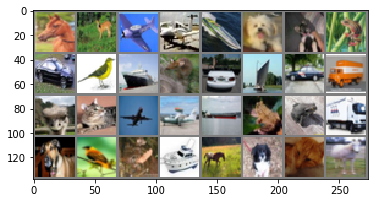

horse	 deer	plane	plane	 ship	  dog	  cat	 frog	  car	 bird	 ship	 deer	  car	 ship	  car	truck	 bird	  cat	plane	plane	 ship	 frog	 frog	truck	  dog	 bird	 frog	 ship	horse	  dog	  cat	horse


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(validloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Model

### simple CNN

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### AlexNet

In [0]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 24, 3, padding=1),  # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Pool1
            nn.Conv2d(24, 96, 3, padding=1),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Pool2
            nn.Conv2d(96, 192, 3, padding=1),  # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 3, padding=1),  # Conv4
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 96, 3, padding=1),  # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Pool3
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(96 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 96 * 4 * 4) 
        x = self.classifier(x)
        return x

## Train

In [0]:
import math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels).item()

            return upd_loss

        optimizer.step(loss.item(), closure)

    return loss.item()

In [0]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        count = 0
        n_ex = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            outputs = model(inputs)
            #outputs_lab = torch.argmax(outputs, 1)
            count += (torch.argmax(outputs, 1) == labels).float().sum().item()
            n_ex += outputs.size(0) 
            val_loss.append(criterion(outputs, labels).item())
        acc.append(count / n_ex)
        if ep % print_every == 0:
            print("Validation loss {}, validation accuracy {}".format(sum(val_loss[-j:]) / j, acc[-1]))
        
    return tr_loss, times, val_loss, lips, grad, acc

In [0]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             }
    return states

In [0]:
print_every = 4
n_epochs = 20
tr_loss = {}
tr_loss['sgd'] = {}
val_loss = {}
val_loss['sgd'] = {}
lrs = [0.001, 0.005]
criterion = nn.CrossEntropyLoss(reduction="mean")
torch.manual_seed(999)

In [0]:
for lr in lrs:
  #model = AlexNet(10)
  model = CNN()
  print("SGD  lr={}, momentum=0. :".format(lr))
  #model = CNN()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0., weight_decay=1e-3)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
             }
  torch.save(states, './CIFAR10/cnn_' + str(lr))

SGD  lr=0.001, momentum=0. :


170500096it [00:50, 6067495.74it/s]                               

Epoch 0, training loss 2.3046078457530723, time passed 0m 15s
Validation loss 2.303295273047227, validation accuracy 0.09986666666666667
Epoch 4, training loss 2.301139187740992, time passed 1m 0s
Validation loss 2.300287951771011, validation accuracy 0.10066666666666667
Epoch 8, training loss 2.294662985816059, time passed 1m 43s
Validation loss 2.2926147259198704, validation accuracy 0.18186666666666668
Epoch 12, training loss 2.198111739952162, time passed 2m 27s
Validation loss 2.156626744148059, validation accuracy 0.23386666666666667
Epoch 16, training loss 1.946737550558096, time passed 3m 10s
Validation loss 1.926912954220405, validation accuracy 0.29786666666666667
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 2.30141891467284, time passed 0m 8s
Validation loss 2.298534059116983, validation accuracy 0.14586666666666667
Epoch 4, training loss 1.7342122878475361, time passed 0m 52s
Validation loss 2.03933955104942, validation accuracy 0.30773333333333336
Epoch 8, training 

In [0]:
for lr in lrs:
  #model = AlexNet(10)
  model = CNN()
  print("SGD  lr={}, momentum=0. :".format(lr))
  #model = CNN()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0., weight_decay=1e-3)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
             }
  torch.save(states, './CIFAR10/cnn_' + str(lr))

SGD  lr=0.001, momentum=0. :
Epoch 0, training loss 2.3033256399703315, time passed 0m 8s
Validation loss 2.3029774947044177, validation accuracy 0.09786666666666667
Epoch 4, training loss 2.2995248004255524, time passed 0m 49s
Validation loss 2.2990700179695063, validation accuracy 0.10426666666666666
Epoch 8, training loss 2.2841472835784935, time passed 1m 33s
Validation loss 2.277648075014098, validation accuracy 0.15453333333333333
Epoch 12, training loss 2.108142703232995, time passed 2m 14s
Validation loss 2.0859479858325076, validation accuracy 0.2614666666666667
Epoch 16, training loss 1.9108273721782558, time passed 2m 58s
Validation loss 1.9045408444526868, validation accuracy 0.31706666666666666
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 2.302613575056375, time passed 0m 9s
Validation loss 2.3004075064618363, validation accuracy 0.10266666666666667
Epoch 4, training loss 1.7911202294460262, time passed 0m 52s
Validation loss 1.7926278577910528, validation accuracy 

In [0]:
model = CNN()
#n_epochs = 4
l_0 = 10
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0., weight_decay=1e-3)
tr_loss['sug'], times, val_loss['sug'], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
        }
torch.save(states, './CIFAR10/cnn_sug')

170500096it [00:40, 7490036.30it/s]                               

Epoch 0, training loss 1.7287127760698997, time passed 0m 18s
Validation loss 1.5798041545427763, validation accuracy 0.4128
Epoch 4, training loss 1.1760990708078964, time passed 1m 25s
Validation loss 1.2566284550051403, validation accuracy 0.5497333333333333
Epoch 8, training loss 0.9532181326614086, time passed 2m 31s
Validation loss 1.1652924087312486, validation accuracy 0.5942666666666667
Epoch 12, training loss 0.8039256114602448, time passed 3m 39s
Validation loss 1.0796798959247067, validation accuracy 0.6341333333333333
Epoch 16, training loss 0.6847569455044815, time passed 4m 48s
Validation loss 1.066927704291466, validation accuracy 0.6490666666666667


In [0]:
for lr in lrs:
  #model = AlexNet(10)
  model = CNN()
  print("SGD  lr={}, momentum=0.9 :".format(lr))
  #model = CNN()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
             }
  torch.save(states, './CIFAR10/cnn_' + str(lr)+'_0.9')

SGD  lr=0.001, momentum=0.9 :
Epoch 0, training loss 2.2413963797580765, time passed 0m 9s
Validation loss 2.047213161093557, validation accuracy 0.2636
Epoch 4, training loss 1.4543043402842728, time passed 0m 56s
Validation loss 1.4251962795726254, validation accuracy 0.4765333333333333
Epoch 8, training loss 1.2309847575084991, time passed 1m 43s
Validation loss 1.2635090781582727, validation accuracy 0.5481333333333334
Epoch 12, training loss 1.0850616734340248, time passed 2m 30s
Validation loss 1.146678028962551, validation accuracy 0.5938666666666667
Epoch 16, training loss 0.9695697107004473, time passed 3m 18s
Validation loss 1.0880737001569862, validation accuracy 0.6208
SGD  lr=0.005, momentum=0.9 :
Epoch 0, training loss 1.9004747491464558, time passed 0m 9s
Validation loss 1.7008630414294381, validation accuracy 0.3910666666666667
Epoch 4, training loss 1.1192579835384007, time passed 0m 54s
Validation loss 1.147972180802598, validation accuracy 0.5872
Epoch 8, training lo

In [0]:
model = CNN()
#n_epochs = 4
l_0 = 10
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.9, weight_decay=1e-3)
tr_loss['sug'], times, val_loss['sug'], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
        }
torch.save(states, './CIFAR10/cnn_sug_0.9')

Epoch 0, training loss 2.0249016348676507, time passed 0m 15s
Validation loss 1.9214284949832492, validation accuracy 0.2730666666666667
Epoch 4, training loss 1.7294441840375763, time passed 1m 24s
Validation loss 1.7247315156154144, validation accuracy 0.3506666666666667
Epoch 8, training loss 1.6675567831619675, time passed 2m 33s
Validation loss 1.660256328745785, validation accuracy 0.3816
Epoch 12, training loss 1.6189166610858527, time passed 3m 47s
Validation loss 1.6111215139046693, validation accuracy 0.39266666666666666
Epoch 16, training loss 1.562051878636142, time passed 4m 57s
Validation loss 1.56002251816611, validation accuracy 0.4196


In [0]:
n_epochs = 30

In [0]:
n_epochs = 30

for lr in lrs:
  model = AlexNet(10)
  #model = CNN()
  print("SGD  lr={}, momentum=0.9 :".format(lr))
  #model = CNN()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-3)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
             }
  torch.save(states, './CIFAR10/alexnet_' + str(lr)+'_0.9')

SGD  lr=0.001, momentum=0.9 :
Epoch 0, training loss 2.30262310928609, time passed 0m 12s
Validation loss 2.302406350771586, validation accuracy 0.09613333333333333
Epoch 4, training loss 1.9233037017914185, time passed 1m 7s
Validation loss 1.795741380789341, validation accuracy 0.32466666666666666
Epoch 8, training loss 1.5064488498561353, time passed 2m 2s
Validation loss 1.435322539673911, validation accuracy 0.4629333333333333
Epoch 12, training loss 1.2342443373727512, time passed 2m 58s
Validation loss 1.1426196865036957, validation accuracy 0.5796
Epoch 16, training loss 1.0220994622368051, time passed 3m 51s
Validation loss 1.0097333478112507, validation accuracy 0.6316
Epoch 20, training loss 0.8725613497018095, time passed 4m 46s
Validation loss 0.8407612826324936, validation accuracy 0.6990666666666666
Epoch 24, training loss 0.757881903953581, time passed 5m 43s
Validation loss 0.770922051408352, validation accuracy 0.7288
Epoch 28, training loss 0.6628517944769687, time p

In [0]:
model = AlexNet(10)
#n_epochs = 4
l_0 = 10
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.9, weight_decay=1e-3)
tr_loss['sug'], times, val_loss['sug'], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
        }
torch.save(states, './CIFAR10/alexnet_sug_0.9')

In [0]:
model = AlexNet(10)
#n_epochs = 4
l_0 = 10
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0., weight_decay=1e-3)
tr_loss['sug'], times, val_loss['sug'], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
        }
torch.save(states, './CIFAR10/alexnet_sug')

In [0]:
n_epochs = 30

for lr in lrs:
  model = AlexNet(10)
  #model = CNN()
  print("SGD  lr={}, momentum=0. :".format(lr))
  #model = CNN()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0., weight_decay=1e-3)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad, acc = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times,
            'acc' : acc
             }
  torch.save(states, './CIFAR10/alexnet_' + str(lr)+'_')